In [1]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
from PIL import Image

In [2]:
from pathlib import Path

## Dataset

The dataset is a set of audio recordings from cats. Samples are short clips (1-2 seconds) grouped in three classes:
- brushing the cat
- cat is in unfamiliar environment (discomfort)
- waiting for food

Source: https://zenodo.org/record/4008297

In [3]:
dataset_dir = Path('/home/flo/projects/data-playground/data/catmeows/wav')

## Convert audio samples into images of spectograms

In [4]:
from scipy.io import wavfile
from scipy import signal
import numpy as np

# source: https://stackoverflow.com/questions/47954034/plotting-spectrogram-in-audio-analysis/47954408
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [5]:
def wav_to_png(path_wav):
    path_png = path_wav.parent.parent / 'png' / f'{path_wav.stem}.png'
    
    # read wave file
    sample_rate, audio = wavfile.read(path_wav)

    # turn audio into spectogram
    freqs, times, specgram = log_specgram(audio, sample_rate)
    
    # bring into range 0..255
    specgram_normed = (specgram + abs(specgram.min())) / (abs(specgram.min()) + specgram.max())
    specgram_normed = (specgram_normed * 255).astype(np.uint8) 
    
    # save as image
    data = Image.fromarray(specgram_normed)
    data.save(path_png)
    return path_png

In [6]:
paths_wav = list(dataset_dir.glob('*.wav'))
paths_png = [
    wav_to_png(path_wav)
    for path_wav
    in paths_wav
]

/home/flo/miniconda3/envs/practice-ml/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


## Look at some example spectrograms

In [7]:
import IPython

def show_sample(idx):
    IPython.display.display(IPython.display.Audio(paths_wav[idx]))
    IPython.display.display(IPython.display.Image(paths_png[idx]))

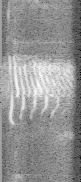

In [8]:
show_sample(20)